In [107]:
iqf = 2e6

In [108]:
import math
import serial
import serial.tools.list_ports
from dataclasses import dataclass
from bitstring import BitArray
import numpy as np
from typing import *

# list available ports
# ports = list(serial.tools.list_ports.comports())
# for p in ports:
#     print(p.device, p.description)

ser = serial.Serial('COM8', baudrate=2e6, timeout=2)  # timeout in seconds
print("Port opened:", ser.is_open)

startSeq = b'[DB,'
stopSeq = b'TRANSMISSION_COMPLETE'
expectedCount = 2

response = b''
try:
    lastCountPrinted = 0
    while True:
        response += ser.read_all()
        nBuffers = response.count(startSeq)
        if nBuffers > lastCountPrinted:
            print(f"\rRead {nBuffers} buffers")
            lastCountPrinted = nBuffers

        if nBuffers == expectedCount and response.find(stopSeq) != -1:
            break
except KeyboardInterrupt:
    pass
finally:
    ser.close()

    
if response.find(b'COMMAND_REJECTED') != -1:
    print("Warning: COMMAND_REJECTED found in response")

print("Read", len(response), "bytes")

@dataclass
class Buffer:
    label: str
    length: int
    granularity: int
    iq: np.ndarray

# [DBA,2028,4=....]
def parseBuffer(raw: bytes, x: int) -> tuple[Buffer, int]:
    x += 1  # skip '['
    print("Parsing Buffer", raw[x:])
    label = ''
    while raw[x] != ord(','):
        label += chr(raw[x])
        x += 1
    x += 1

    length = ''
    while raw[x] != ord(','):
        length += chr(raw[x])
        x += 1
    length = int(length)
    x += 1

    granularity = ''
    while raw[x] != ord('='):
        granularity += chr(raw[x])
        x += 1
    granularity = int(granularity)
    x += 1

    nBytes = math.ceil((length * 2 * granularity) / 8)
    bits = BitArray(bytes=raw[x:x+nBytes])

    # Build a numpy array of shape (length, 2). Use int32 to avoid overflow issues.
    values: list[tuple[int, int]] = []
    rescale = 1 << (16 - granularity)
    for bitslice in bits.cut(granularity * 2):
        i_val = bitslice[0:granularity].int * rescale
        q_val = bitslice[granularity:granularity*2].int * rescale
        values.append((i_val, q_val))
    IQ_array = np.asarray(values, dtype=np.int16)
    x += nBytes + 1

    return Buffer(
        label,
        length,
        granularity,
        IQ_array
    ), x

IQ = np.empty((0, 2), dtype=np.int16)
i = 0
n = 0
while True:
    i = response.find(startSeq, i)
    if i == -1:
        break
    n += 1
    try:
        buf, i = parseBuffer(response, i)
        # stack buffer IQ arrays vertically into the global IQ array
        if buf.iq.size:
            IQ = np.vstack((IQ, buf.iq))
    # except None:
    #     print("Last buffer incomplete")
    #     break
    finally:
        pass

print("Parsed", n, "buffers,", len(IQ), "IQ pairs total")


Port opened: True
Read 1 buffers
Read 2 buffers
Read 28127 bytes
Parsing Buffer b'DB,3500,16=\x11\x00\xff\xff\x12\x00\xfa\xff\x0f\x00\xf9\xff\t\x00\xfa\xff\x01\x00\xfc\xff\xfa\xff\xfc\xff\xf4\xff\xfd\xff\xf2\xff\x00\x00\xf4\xff\x05\x00\xfa\xff\n\x00\x03\x00\x0e\x00\x0b\x00\x0b\x00\x10\x00\x03\x00\x0e\x00\xf8\xff\x08\x00\xee\xff\x00\x00\xeb\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfa\xff\x03\x00\x00\x00\x01\x00K\x00\xdd\xff\x01\x01i\xff\xec\x01\xad\xfeh\x02\x0b\xfe\xaa\x01$\xfe\x87\xffe\xff\x13\xfdj\x01Z\xfc\xd2\x02\xe7\xfe\x08\x02\x04\x04\xab\xfe@\x08\x8c\xfaV\x07\x11\xf9\xbd\xff\xcb\xfcK\xf5\xbb\x04\x1e\xf0\xa0\x0bG\xf7\xc8\n#\nX\xffz\x1d\x83\xee\xb8\x1f\x01\xe5\x0f\x03\xbe\xf0\x8a\xc7\xfe\x17\x00\x80\x90S\x00\x80\xff\x7f\x00\x80\xff\x7f\x00\x80\xff\x7f\x00\x80\xff\x7fN\xe4c!\x85\xec\xea\x18\xbd\xee\x90\x14\x83\xec\x93\x14S\xe9\xd0\x16 \xe8\x8b\x18\xd1\xe9)\x18I\xed\xc9\x15\xaa\xf0\xb9\x12\xb6\xf2J\x10^\xf3\x06\x0fm\xf3\x96\x

In [109]:
# load all files from "records" directory (0001.npy)
dir = 'records'
IQ_STORE: dict[str, np.ndarray] = {}
import os
for filename in os.listdir(dir):
    if filename.endswith('.npy'):
        filepath = os.path.join(dir, filename)
        iq_data = np.load(filepath)
        IQ_STORE[filename] = iq_data
        print(f"Loaded {filepath}, shape: {iq_data.shape}")
try:
    lastN = max([int(name.split('.')[0]) for name in IQ_STORE.keys()])
    lastN += 1
except ValueError:
    lastN = 0
thisFile = f"{lastN:04d}.npy"
np.save(f'{dir}/{thisFile}', IQ)
IQ_STORE[thisFile] = IQ


Loaded records\0000.npy, shape: (7000, 2)
Loaded records\0001.npy, shape: (7000, 2)
Loaded records\0002.npy, shape: (7000, 2)
Loaded records\0003.npy, shape: (7000, 2)


In [110]:
for name, iq_data in IQ_STORE.items():
    print(f"{name}: {iq_data.shape}")

0000.npy: (7000, 2)
0001.npy: (7000, 2)
0002.npy: (7000, 2)
0003.npy: (7000, 2)
0004.npy: (7000, 2)


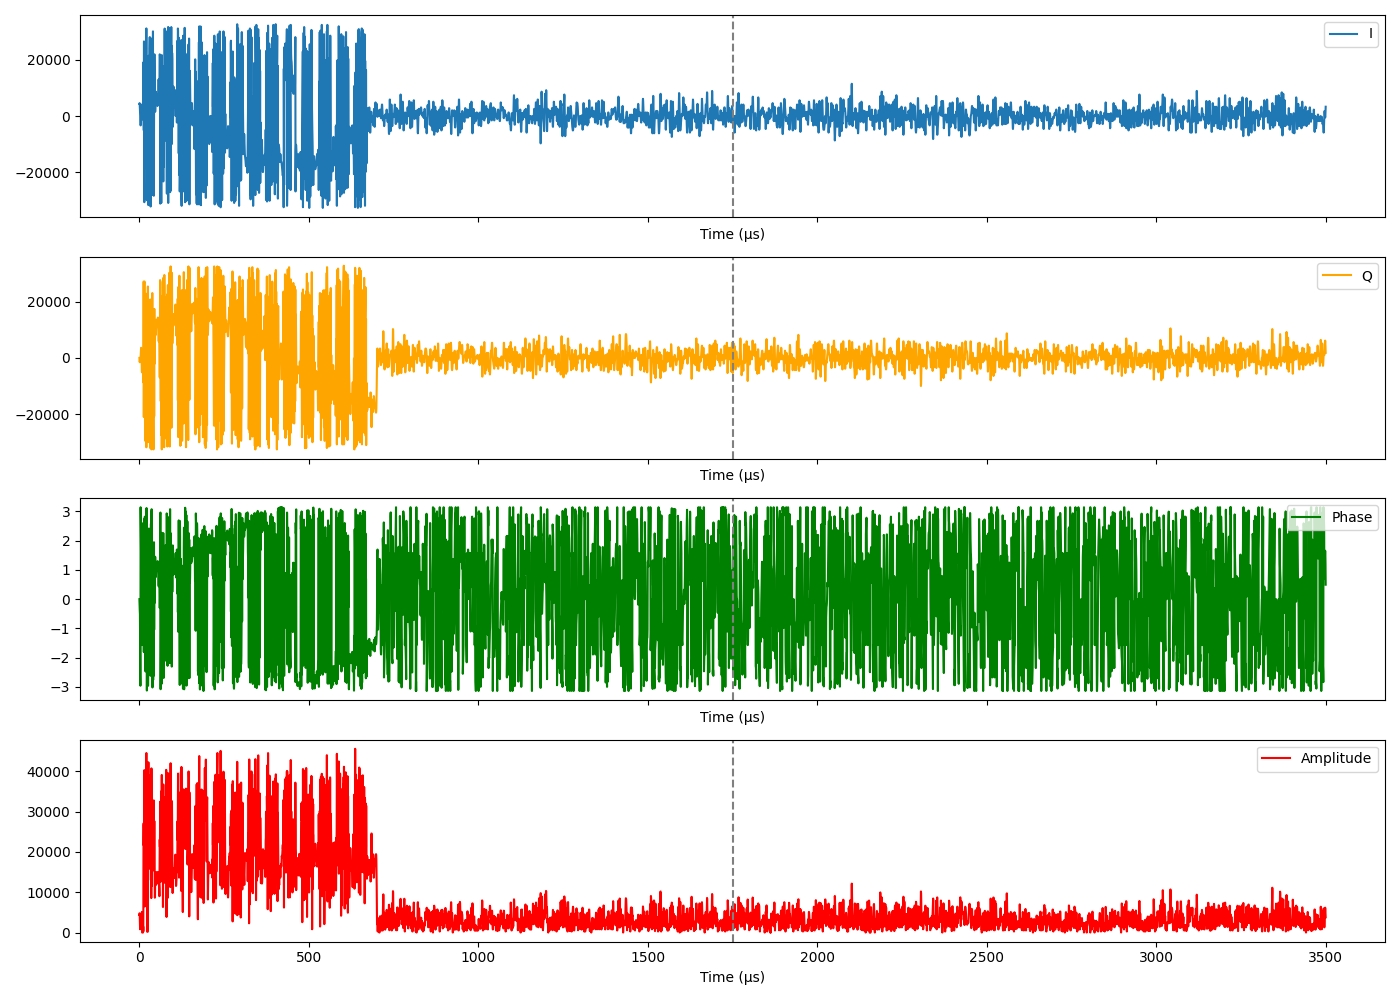

In [111]:
%matplotlib widget
import matplotlib.pyplot as plt

# IQ is now a numpy array with shape (N, 2)
I, Q = IQ[:, 0], IQ[:, 1]
phase = np.arctan2(Q, I)
A = np.hypot(I, Q)

try:
    microSecondsPerSample = 1e6 / iqf
    time = [i * microSecondsPerSample for i in range(len(IQ))]
    timeLabel = 'Time (µs)'
except NameError:
    time = list(range(len(IQ)))
    timeLabel = 'nSample'

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 10))
axs: list[plt.Axes]
(ax1, ax2, ax3, ax4) = axs
ax1.plot(time, I, label='I')
ax1.legend(loc='upper right')
ax2.plot(time, Q, label='Q', color='orange')
ax2.legend(loc='upper right')
ax3.plot(time, phase, label='Phase', color='green')
ax3.legend(loc='upper right')
ax4.plot(time, A, label='Amplitude', color='red')
ax4.legend(loc='upper right')

for ax in axs:
    ax.axvline(time[len(time)//2], color='gray', linestyle='--')
    ax.set_xlabel(timeLabel)

plt.tight_layout()
plt.show()


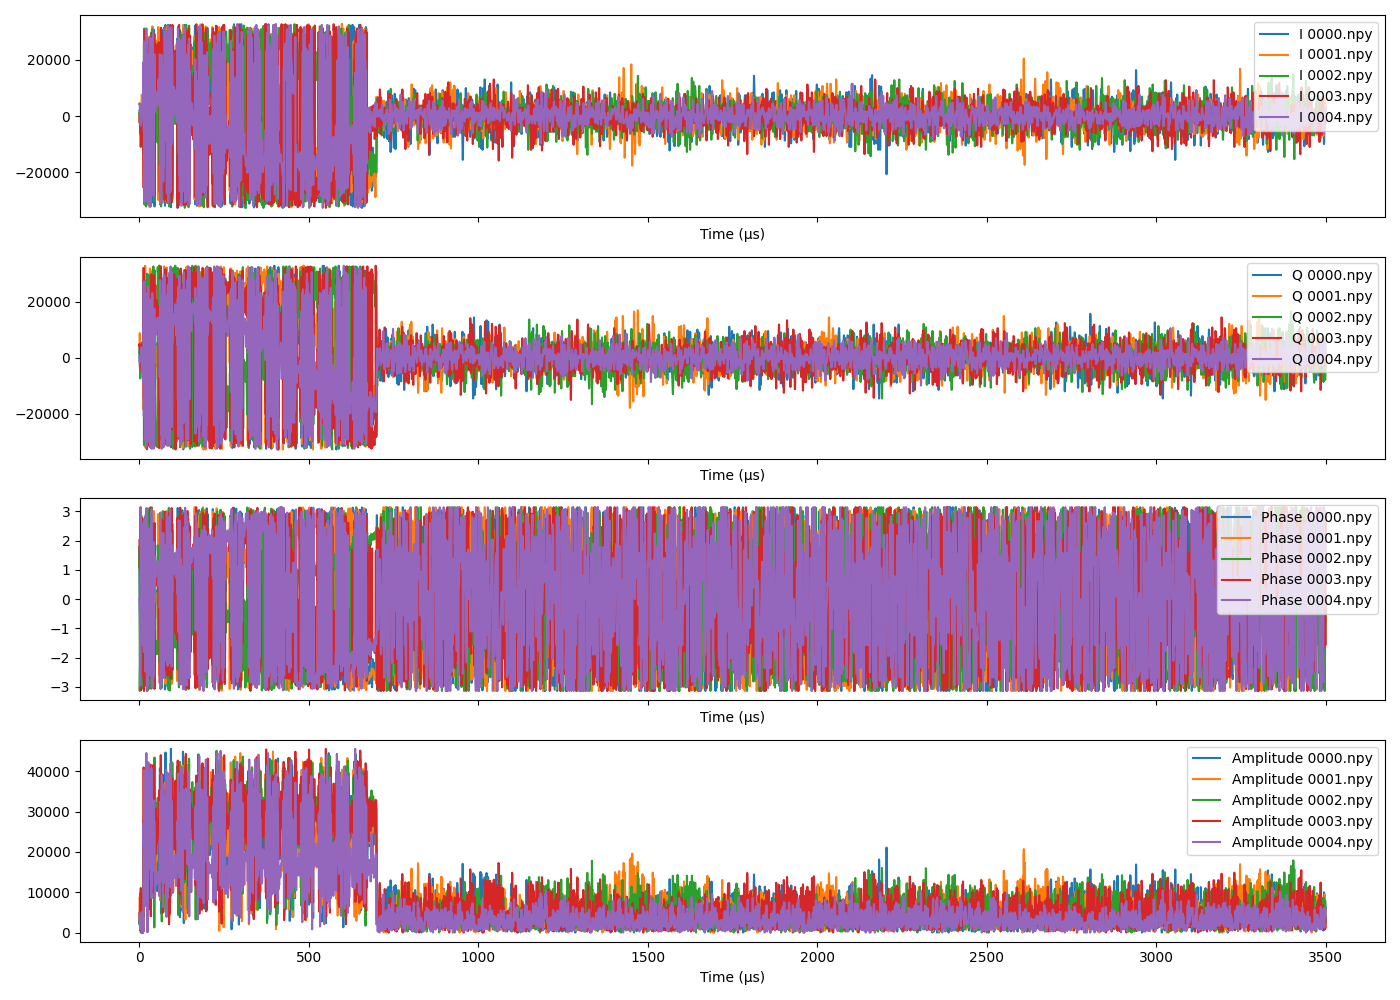

In [112]:
%matplotlib widget
import matplotlib.pyplot as plt

try:
    microSecondsPerSample = 1e6 / iqf
    time = [i * microSecondsPerSample for i in range(len(IQ))]
    timeLabel = 'Time (µs)'
except NameError:
    time = list(range(len(IQ)))
    timeLabel = 'nSample'

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 10))
axs: list[plt.Axes]
(ax1, ax2, ax3, ax4) = axs

for name, IQ in IQ_STORE.items():
    I, Q = IQ[:, 0], IQ[:, 1]
    phase = np.arctan2(Q, I)
    A = np.hypot(I, Q)
    ax1.plot(time, I, label=f'I {name}')
    ax1.legend(loc='upper right')
    ax2.plot(time, Q, label=f'Q {name}')
    ax2.legend(loc='upper right')
    ax3.plot(time, phase, label=f'Phase {name}')
    ax3.legend(loc='upper right')
    ax4.plot(time, A, label=f'Amplitude {name}')
    ax4.legend(loc='upper right')

for ax in axs:
    ax.set_xlabel(timeLabel)

plt.tight_layout()
plt.show()